In [1]:
import os, sys, io, time
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool
from pax.utils import Memoize
from numba import vectorize, guvectorize, int64, int32

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str): plt.colorbar(label = colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')
    else: pass

In [2]:
# Check existing file list
class dummy_read_n_merge():
    __version__ = '0.1.6'
    
    def process(self,
                indir_larges2='', indir_peak='', indir_elist='',
                outdir_peak='', outdir_elist='', number_file_cap=0):

        self.indir = dict(larges2 = indir_larges2, peak = indir_peak, elist = indir_elist)
        self.outdir = dict(larges2 = indir_larges2, peak = outdir_peak, elist = outdir_elist)
        
        # Record all the file in folder, and put a cup on number of files
        file_list = [[f for f in os.listdir(d) if 'pkl' in f] for d in self.indir.values()]
        file_list = list(set(file_list[0]).intersection(file_list[1]).intersection(file_list[2]))

        self.file_list = file_list[:number_file_cap]

io_dir = dict (
    indir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist/', # Elist In
    indir_larges2 = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/LargeS2/', # Large S2 In
    indir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/PreTriggerPeaks/', # Pre Trigger Peak In
    outdir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist_Processed/', # Processed Peak Out
    outdir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Peaks_Processed/',) # Processed Elist Out

In [50]:
drnm = dummy_read_n_merge()
drnm.process(number_file_cap = 1000, **io_dir)
flist = drnm.file_list

print('Loading Data..')
time.sleep(1)
def load_data(outdir_key):
    cache = []
    with tqdm(total=len(flist)) as pBar:
        for file in flist:
            pBar.update(1)
            cache.append(pd.read_pickle(os.path.join(io_dir[outdir_key], file)))
    return pd.concat(cache)

df = load_data('outdir_peak')
#df_elist = load_data('outdir_elist')

Loading Data..


100%|██████████| 1000/1000 [01:06<00:00, 15.14it/s]


In [44]:
# 1D live time calculation, delay from previous s2 as x axis
@vectorize([int64(int64, int64, int64, int64)])
def func_nb(a1, a2, b1, b2):
    # Calculate the over lap between two segments on an axis
    return min(a2, b2) - max(a1, b1)

def GetD1LiveTimeSingleFile(file):
    # A1: left x-axis bin edges, A2: right x-axis bin edges
    df = pd.read_pickle(os.path.join(io_dir['outdir_elist'], file))
    df = df[df.eval('CutDAQVeto')]

    df['search_window'] = np.clip(df.s1_center_time, 0, 1e6)
    df.loc[~(df.search_window>0), 'search_window'] = 1e6

    B1 = np.asarray(df.event_time-df.previous_largest_s2_time, dtype=int)
    B2 = np.asarray(df.event_time-df.previous_largest_s2_time+df.search_window, dtype=int)

    # Here is where magic happens
    Ag1, Bg1 = np.meshgrid(A1, B1, sparse=False, indexing='ij')
    Ag2, Bg2 = np.meshgrid(A2, B2, sparse=False, indexing='ij')
    # Dim 2 live time with indicies: (Index of delay from previous s2, index of events)
    D2lt = func_nb(Ag1.reshape((-1,)), Ag2.reshape((-1,)), Bg1.reshape((-1,)), Bg2.reshape((-1,)))
    D2lt = D2lt.reshape((A1.shape[0], B1.shape[0]))
    D2lt[D2lt < 0] = 0; D2lt = D2lt/1e9; # change live time unit to s, it is more natual for event rate
    return np.sum(D2lt, axis=1) # collapse event id axis

def GetD1LiveTime(flist):
    with Pool(processes=25, maxtasksperchild=50) as pool:
        list_of_D1lt = list(tqdm(pool.imap(GetD1LiveTimeSingleFile, flist, 2), total=len(flist)))
    return np.sum(np.array(list_of_D1lt), axis=0)

# Setting axis binning
time_range = [0, 1500] # ms (though confusing, ms is more natural unit for delay from previous s2)
# Change unit to ns and split into 1000 bins
time_bin_edges = np.linspace(time_range[0]*1e6, time_range[1]*1e6, 1500+1)
time_bin_size = time_bin_edges[1] - time_bin_edges[0] 
time_bin_centers = 0.5*(time_bin_edges[:-1] + time_bin_edges[1:]) # Still in ns

A1 = np.asarray(time_bin_edges[:-1], dtype=int)
A2 = np.asarray(time_bin_edges[1:], dtype=int)

D1lt = GetD1LiveTime(flist) # It use A1 and A2 as global input

100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


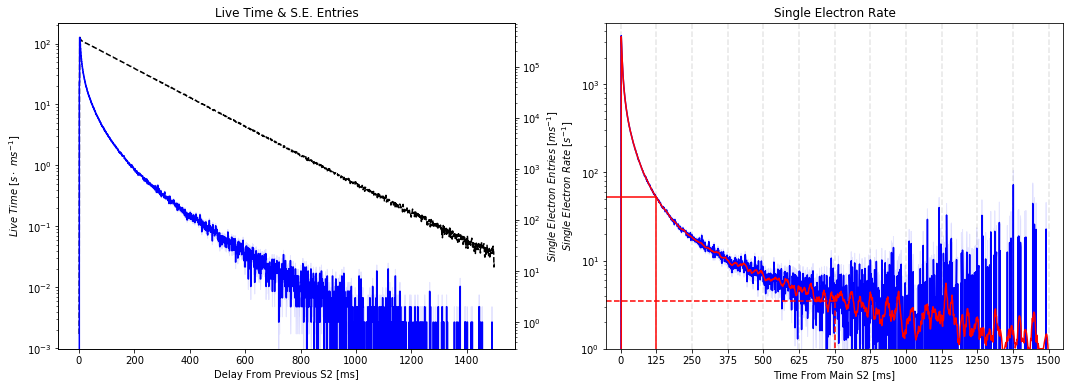

In [48]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
plt.plot(time_bin_centers/1e6, D1lt, color = 'k', ls = '--')
plt_config(title = 'Live Time & S.E. Entries', xlabel = 'Delay From Previous S2 [ms]', ylabel = '$Live\ Time\ [s\cdot\ ms^{-1}]$')
plt.yscale('log')

ax_t = ax.twinx()
df['delay'] = df.hit_time_mean_global - df.previous_largest_s2_time
ph = Hist1d(df.delay/1e6, bins = time_bin_edges/1e6) # So x is in ms, y is in entries / (time_range/1000)
upper_err, lower_err = lambda n: n+sqrt(n), lambda n: n-sqrt(n)
plt.fill_between(ph.bin_centers, lower_err(ph.histogram),upper_err(ph.histogram), color='b', alpha=0.1)
ph.plot(color='b')
plt_config(ylabel = '$Single\ Electron\ Entries\ [ms^{-1}]$')
plt.yscale('log')

########################################################################
ax = fig.add_subplot(122)
rate = ph.histogram/D1lt

plt.plot(ph.bin_centers, rate, color='b')
plt.fill_between(ph.bin_centers, lower_err(ph.histogram)/D1lt,upper_err(ph.histogram)/D1lt, color='b', alpha=0.1)

from scipy.signal import savgol_filter
y = np.log10(rate)[2:]; y[y<0] = 0
y_smooth = savgol_filter(y, window_length = 25, polyorder = 3)
intp = interp1d(ph.bin_centers[2:], 10**y_smooth, fill_value = [-4], bounds_error = False)

plt.plot(np.linspace(-50,125,10),intp(125)*np.ones(10), 125*np.ones(10), np.linspace(1e-6,intp(125),10),color = 'r')
plt.plot(np.linspace(-50,750,10),intp(750)*np.ones(10), 750*np.ones(10), np.linspace(1e-6,intp(750),10),color = 'r', ls = '--')
plt.plot(ph.bin_centers, intp(ph.bin_centers), 'r')

plt_config(title = 'Single Electron Rate', xlabel = 'Time From Main S2 [ms]', ylabel = '$Single\ Electron\ Rate\ [s^{-1}]$',
           xbounds = [-50, 1550], ybounds = [1, 5e3],)
plt.yscale('log'); plt.xticks(np.linspace(0,1500,13))
plt.grid(color = 'grey', ls = '--', lw = 0.3, axis = 'x')

plt.show()

In [59]:
# 2D live time calculation, delay from previous s2 as x axis, previous s2 area as y axis
@vectorize([int64(int64, int64, int64, int64)])
def func_nb(a1, a2, b1, b2):
    # Calculate the over lap between two segments on an axis
    return min(a2, b2) - max(a1, b1)

def BinS2AreaAxis(df, D2lt):
    df['binned_lt'] = list(D2lt.T)
    df['area_index'] = np.digitize(df.previous_largest_s2_area, mh.bin_edges[1][1:])
    df.sort_values(by='area_index', inplace=True)

    uniarea, unindices = np.unique(df.area_index.values, return_index=True)
    # In the following
    # D3lt indicies: (Area, Sub Area, Delay)
    # d2lt indicies: (Sub area, Delay) -> we use it to collapse 'Sub area' index essentially events
    # D2lt indicies: (Area, Delay) -> we need to patch up missing ones

    D3lt = np.split(df.binned_lt.values, indices_or_sections = unindices)[1:-1]
    _D2lt = np.array([np.sum(d2lt, axis=0) for d2lt in D3lt])

    D2lt = np.zeros_like(mh.histogram)
    D2lt[:, uniarea[:-1]] += _D2lt.T
    return D2lt

def GetD2LiveTimeSingleFile(file):
    # A1: left x-axis bin edges, A2: right x-axis bin edges
    df = pd.read_pickle(os.path.join(io_dir['outdir_elist'], file))
    df = df[df.eval('CutDAQVeto')]
    df['previous_largest_s2_area'] = [np.amax(areas) for areas in df.previous_s2_areas.values]

    df['search_window'] = np.clip(df.s1_center_time, 0, 1e6)
    df.loc[~(df.search_window>0), 'search_window'] = 1e6

    B1 = np.asarray(df.event_time-df.previous_largest_s2_time, dtype=int)
    B2 = np.asarray(df.event_time-df.previous_largest_s2_time+df.search_window, dtype=int)

    # Here is where real magic happens
    Ag1, Bg1 = np.meshgrid(A1, B1, sparse=False, indexing='ij')
    Ag2, Bg2 = np.meshgrid(A2, B2, sparse=False, indexing='ij')
    # Dim 2 live time with indicies: (Index of delay from previous s2, index of events)
    D2lt = func_nb(Ag1.reshape((-1,)), Ag2.reshape((-1,)), Bg1.reshape((-1,)), Bg2.reshape((-1,)))
    D2lt = D2lt.reshape((A1.shape[0], B1.shape[0]))
    D2lt[D2lt < 0] = 0; D2lt = D2lt/1e9; # change live time unit to s, it is more natual for event rate
    return BinS2AreaAxis(df, D2lt) # Basically collapes events according to area

def GetD2LiveTime(flist):
    with Pool(processes=25, maxtasksperchild=50) as pool:
        list_of_D1lt = list(tqdm(pool.imap(GetD2LiveTimeSingleFile, flist, 2), total=len(flist)))
    return np.sum(np.array(list_of_D1lt), axis=0)

# Setting axis binning
time_range = [0, 1500] # ms (though confusing, ms is more natural unit for delay from previous s2)
# Change unit to ns and split into 1000 bins
time_bin_edges = np.linspace(time_range[0]*1e6, time_range[1]*1e6, 1500+1)
time_bin_size = time_bin_edges[1] - time_bin_edges[0] 
time_bin_centers = 0.5*(time_bin_edges[:-1] + time_bin_edges[1:]) # Still in ns

A1 = np.asarray(time_bin_edges[:-1], dtype=int)
A2 = np.asarray(time_bin_edges[1:], dtype=int)

area_range = [1e2, 1e7] # pe
area_bin_edges = np.logspace(np.log10(area_range[0]),  np.log10(area_range[1]), 101)
argx, argy = '{df}.delay/1e6', '{df}.previous_largest_s2_area'
dfs = ['df[df.previous_largest_s2_area > 0]']
df['delay'] = df.hit_time_mean_global - df.previous_largest_s2_time
mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
            bins=[time_bin_edges/1e6, area_bin_edges])

D2lt = GetD2LiveTime(flist) # It use A1, A2 and mh as global input

100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


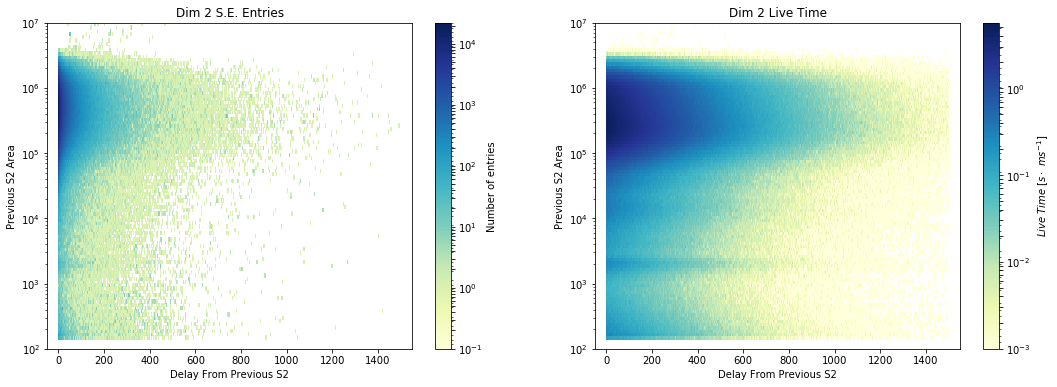

In [17]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
mh.plot(log_scale = True, cmap=plt.get_cmap('YlGnBu'), log_scale_vmin=1e-1,
        alpha = 1.0, cblabel='Number of entries')
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 S.E. Entries',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area')

########################################################################
ax = fig.add_subplot(122)
mh_lt = Histdd.from_histogram(D2lt, mh.bin_edges)
mh_lt.plot(log_scale = True, cmap=plt.get_cmap('YlGnBu'), log_scale_vmin=1e-3, 
           alpha = 1.0, cblabel='$Live\ Time\ [s\cdot\ ms^{-1}]$')
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 Live Time',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area')

plt.show()

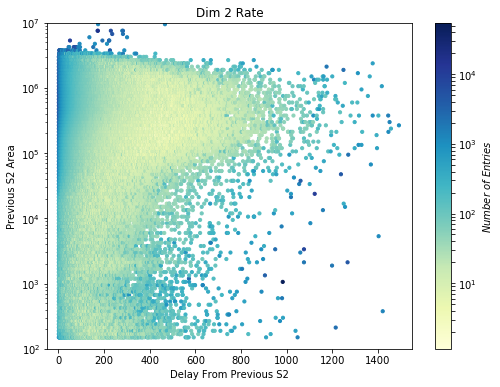

In [19]:
plt.rcParams['figure.figsize'] = (18, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
rate = np.true_divide(mh.histogram, mh_lt.histogram)
rate[np.isnan(rate)] = 0
rate[np.isinf(rate)] = 0

grid = np.array(np.meshgrid(mh.bin_centers(axis=0), mh.bin_centers(axis=1), indexing = 'ij'))
plt.scatter(grid[0], grid[1], c = rate, cmap = plt.get_cmap('YlGnBu'), norm = LogNorm(), s = 10)
plt.yscale('log')
plt_config(xbounds = [-50, 1550], ybounds = [1e2, 1e7], title = 'Dim 2 Rate',
           xlabel = 'Delay From Previous S2', ylabel = 'Previous S2 Area', colorbar = True)

plt.show()

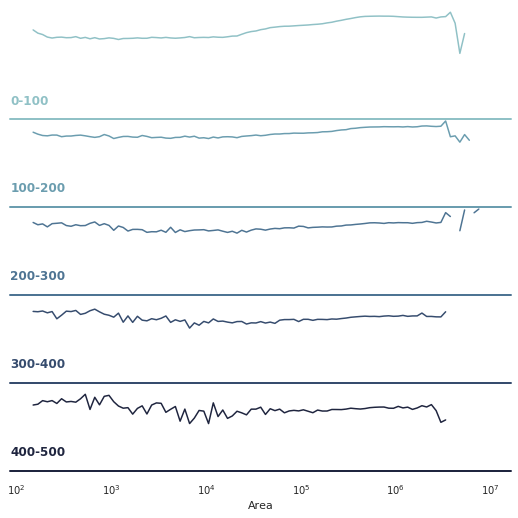

In [88]:
plt.rcParams['figure.figsize'] = (12, 10)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)

tmp = pd.DataFrame(dict(Area = ['0-100', '100-200', '200-300', '300-400', '400-500',
                               ],
                        i = [0, 1, 2, 3, 4]
                       ))
g = sns.FacetGrid(tmp, row="Area", hue="Area", aspect=5, size=1.5, palette=pal)

ys = np.split(rate, 15)[:5]
ys = [np.sum(y, axis=0) for y in ys]
def plotting(i, **kwarg):
    plt.plot(mh.bin_centers(axis=1), np.log10(ys[i.values[0]]), **kwarg)

g.map(plotting, 'i',  alpha=1, lw=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, label, **kwarg):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=kwarg['color'], 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Area")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.xscale('log')

plt.show()

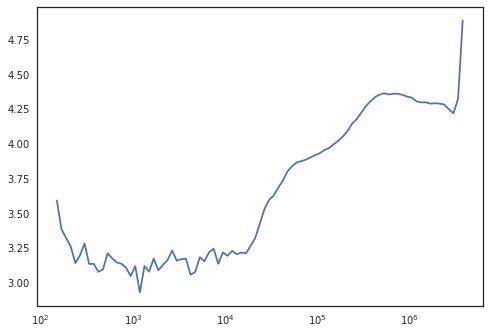

In [92]:
plt.plot(mh.bin_centers(axis=1), np.log10(np.sum(rate[3:13,:], axis = 0)))
plt.xscale('log')
plt.show()